<a href="https://colab.research.google.com/github/kiseonjeong/computer-vision/blob/2-study-the-super-resolution-algorithm/super%20resolution/cifar10_fsrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Set input layer
inputs = keras.Input(shape=(32, 32, 3), name='img')

# Patch extraction layer
x = layers.Conv2D(
    filters=56,
    kernel_size=5,
    padding='same',
)(inputs)
x = keras.layers.PReLU()(x)

# Shrinking layer
x = layers.Conv2D(
    filters=16,
    kernel_size=1,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)

# Non-linear mapping layer
x = layers.Conv2D(
    filters=12,
    kernel_size=3,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)
x = layers.Conv2D(
    filters=12,
    kernel_size=3,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)
x = layers.Conv2D(
    filters=12,
    kernel_size=3,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)
x = layers.Conv2D(
    filters=12,
    kernel_size=3,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)

# Expanding layer
x = layers.Conv2D(
    filters=56,
    kernel_size=1,
    padding='same',
)(x)
x = keras.layers.PReLU()(x)

# Reconstruction layer
outputs = layers.Conv2DTranspose(
    filters=3,
    kernel_size=9,
    strides=(4, 4),
    padding='same'
)(x)

# Set a FSRCNN model
model = keras.Model(inputs, outputs, name='FSRCNN')
model.summary()

Model: "FSRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 56)        4256      
                                                                 
 p_re_lu (PReLU)             (None, 32, 32, 56)        57344     
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        912       
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 16)        16384     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 12)        1740      
                                                                 
 p_re_lu_2 (PReLU)           (None, 32, 32, 12)        12288

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

170508288/170498071 [==============================] - 3s 0us/step


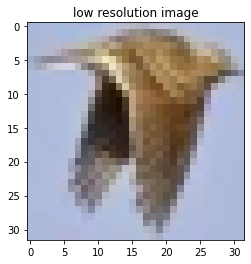

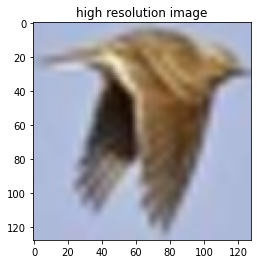

In [4]:
# Load image data
ishape = 128
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Reduce the dataset
train_image = train_images[0:10000]
test_image = test_images[0:1000]

x_train = np.array([img for img in train_image])
x_test = np.array([img for img in test_image])

y_train = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in train_image])
y_test = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in test_image])

# Show an example image
example_idx = 123
plt.figure('LR')
plt.imshow(x_train[example_idx])
plt.title('low resolution image')
plt.figure('HR')
plt.imshow(y_train[example_idx])
plt.title('high resolution image')
plt.show()

In [5]:
# Train the model
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=255.0)

model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='mse', metrics=[PSNR, SSIM, 'accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', test_scores[0])
print('Test mse:', test_scores[1])

# Save entire model to a HDF5 file
model.save('FSRCNN.h5')

Epoch 1/10
125/125 [==============================] - 26s 98ms/step - loss: 7397.1338 - PSNR: 11.7768 - SSIM: 0.2378 - accuracy: 0.3697 - val_loss: 1831.7527 - val_PSNR: 15.9386 - val_SSIM: 0.4936 - val_accuracy: 0.4001
Epoch 2/10
125/125 [==============================] - 11s 90ms/step - loss: 1405.2883 - PSNR: 17.1805 - SSIM: 0.5210 - accuracy: 0.4175 - val_loss: 1125.1863 - val_PSNR: 18.0748 - val_SSIM: 0.5597 - val_accuracy: 0.4187
Epoch 3/10
125/125 [==============================] - 11s 90ms/step - loss: 944.3876 - PSNR: 18.9678 - SSIM: 0.5951 - accuracy: 0.4244 - val_loss: 801.8320 - val_PSNR: 19.6915 - val_SSIM: 0.6315 - val_accuracy: 0.4070
Epoch 4/10
125/125 [==============================] - 11s 89ms/step - loss: 715.8616 - PSNR: 20.3361 - SSIM: 0.6546 - accuracy: 0.4181 - val_loss: 643.4881 - val_PSNR: 20.8295 - val_SSIM: 0.6814 - val_accuracy: 0.4133
Epoch 5/10
125/125 [==============================] - 11s 90ms/step - loss: 602.3038 - PSNR: 21.2555 - SSIM: 0.6989 - accura

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


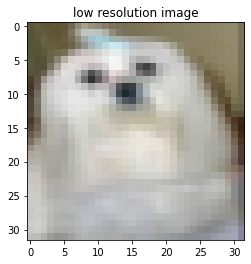

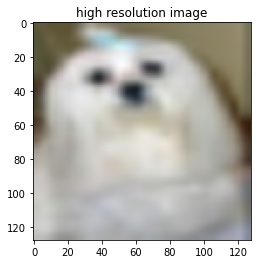

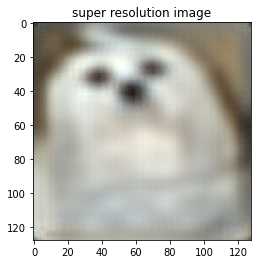

In [6]:
# Set real test image
img = train_images[20001]
lr = np.array(img)
hr = np.array(cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC))
test_input = np.reshape(lr, (1, 32, 32, 3))

# Predict a result
sr = model.predict(test_input)
plt.figure('LR')
plt.title('low resolution image')
plt.imshow(lr)
plt.figure('HR')
plt.title('high resolution image')
plt.imshow(hr)
plt.figure('SR')
plt.title('super resolution image')
plt.imshow(sr[0] / 255.0)
plt.show()